In [12]:
from music21 import *
import pandas as pd
import glob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
# Small LSTM Network to Generate Text for Alice in Wonderland
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import sys

In [13]:
%matplotlib inline

In [15]:
#path = '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi'
path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical'

In [18]:
#files = glob.glob('{}/*.mid*'.format(path))
files = glob.glob(path)

In [19]:
files

['/home/eurismar/notebooks/c-rnn-gan/datadir/classical']

In [22]:
import os

In [30]:
path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical'

In [31]:
diretorios = [x for x in os.listdir(path)]

In [40]:
diretorios[:5]

['mahler', 'bach_teste', 'meyerbeer', 'yradier', 'vivaldi']

In [69]:
files = []
for x in diretorios[:2]:
  a = path+'/'+x
  files_part = glob.glob('{}/*.mid*'.format(a))
  print(a+"\n")
  files = files + files_part

/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler

/home/eurismar/notebooks/c-rnn-gan/datadir/classical/bach_teste



In [70]:
files

['/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1396mahler55.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1394mahl4mov1.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1397sym1mov1.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1395mahl4mov3.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/559symphonyno5.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1398sym1mov2.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/bach_teste/air.mid',
 '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/bach_teste/2467lvbminuet.mid']

In [71]:
#path = '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi'
#files = glob.glob('{}/*.mid*'.format(path))

In [73]:
file = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1396mahler55.mid'

midi = converter.parse(file)

In [72]:
coluna1 = []
coluna2 = []
coluna3 = []
for file in files:
    print(file)
    midi = converter.parse(file)
    part0 = midi[0]

    melodia = part0.getElementsByClass(note.Note)
    notas = melodia.getElementsByClass(note.Note)
    for nota in notas:
        coluna1.append(nota.pitch.midi)
        coluna2.append(nota.duration.quarterLength)
        coluna3.append(str(nota.pitch.midi)+","+str(nota.duration.quarterLength))

/home/eurismar/notebooks/c-rnn-gan/datadir/classical/mahler/1396mahler55.mid


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame({"nota":coluna1,"duracao":coluna2,"nota_duracao":coluna3})

In [ ]:
df.head()

In [8]:
nota_duracao = df.values[::,2]

In [9]:
nota_duracao.shape

(5893,)

In [10]:
# create mapping of unique chars to integers
chars = sorted(list(set(nota_duracao)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [11]:
n_chars = len(nota_duracao)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  5893
Total Vocab:  237


In [12]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
	seq_in = nota_duracao[i:i + seq_length]
	seq_out = nota_duracao[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  5793


In [13]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,shuffle=False)

In [39]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
#model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]),return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(512))
#model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 237)               121581    
Total params: 1,960,685
Trainable params: 1,960,685
Non-trainable params: 0
_________________________________________________________________


In [45]:
!rm weights-improvemen*

In [42]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [43]:
history = model.fit(X, y,validation_data=(X_test,y_test), epochs=20, batch_size=128, callbacks=callbacks_list,shuffle=False)

Train on 5793 samples, validate on 580 samples
Epoch 1/20
5793/5793 [==============================] - 36s - loss: 5.8645 - acc: 0.0337 - val_loss: 5.5173 - val_acc: 0.0517
Epoch 2/20
5793/5793 [==============================] - 40s - loss: 5.4270 - acc: 0.0371 - val_loss: 5.4309 - val_acc: 0.0517
Epoch 3/20
5793/5793 [==============================] - 35s - loss: 5.4267 - acc: 0.0378 - val_loss: 5.4438 - val_acc: 0.0517
Epoch 4/20
5793/5793 [==============================] - 37s - loss: 5.4480 - acc: 0.0373 - val_loss: 5.4778 - val_acc: 0.0517
Epoch 5/20
5793/5793 [==============================] - 38s - loss: 5.4450 - acc: 0.0342 - val_loss: 5.4599 - val_acc: 0.0517
Epoch 6/20
5793/5793 [==============================] - 34s - loss: 5.4483 - acc: 0.0364 - val_loss: 5.4822 - val_acc: 0.0517
Epoch 7/20
5793/5793 [==============================] - 35s - loss: 5.4605 - acc: 0.0352 - val_loss: 5.4506 - val_acc: 0.0517
Epoch 8/20
5793/5793 [==============================] - 34s - loss: 5.4

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


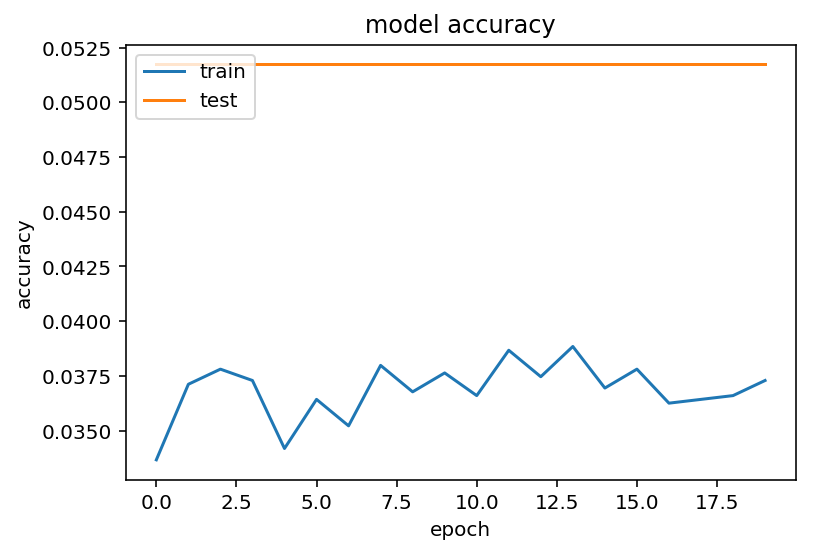

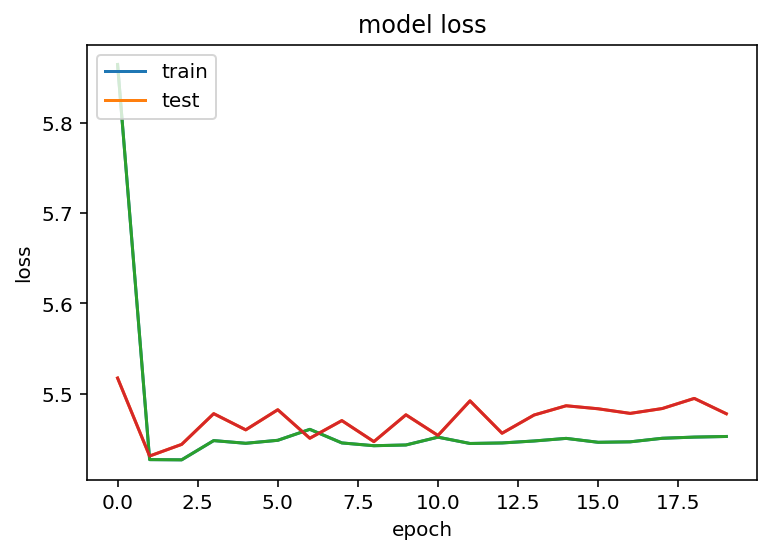

In [44]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [25]:
# load the network weights
filename = "weights-improvement-19-3.5428.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [26]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [27]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
print('-------------------------------------')
# generate characters
for i in range(1000):
	x = numpy.reshape(pattern, (1, len(pattern), 1))
	x = x / float(n_vocab)
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" 60,3.564,0.567,1.067,1.064,1.065,1.064,0.562,2.564,0.567,1.067,1.064,0.564,0.565,0.564,1.062,2.560,2.062,2.064,2.065,1.065,1.064,4.067,1.065,0.564,1.057,0.559,0.2560,0.7562,0.2560,0.555,0.7557,0.559,0.2560,0.562,0.560,1.2557,0.559,0.2560,0.7560,0.2562,0.2560,0.2555,0.564,0.7565,0.564,0.2562,0.7564,0.2560,0.2562,1.057,0.559,0.2560,0.562,0.7560,0.2555,0.7557,0.559,0.2560,0.562,0.560,1.2557,0.559,0.2560,0.555,0.2555,0.567,0.564,0.560,0.2557,0.7565,0.564,0.2562,0.7564,0.2562,1.055,0.2560,0.2560,0.2560,0.2560,0.2560,0.2560,0.2562,0.564,1.060,0.2560,0.2560,0.2560,0.2560,0.564,0.559,0.559,0.560,0.560,0.2560,0.2560,0.2560,0.2560,0.2560,0.2562,0.5 "
-------------------------------------
60,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.